# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Primary Analysis
For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?

In [1]:
import os
import sys


In [2]:
# Get the current working directory (optional, for verification)
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

# Change the working directory to the parent directory
os.chdir('..')

# Get the new current working directory (optional, for verification)
new_directory = os.getcwd()
print(f"New current directory: {new_directory}")


Current directory: /workspaces/basic-python/unlearning-research-meta/experiments/deletion_capacity/notebooks
New current directory: /workspaces/basic-python/unlearning-research-meta/experiments/deletion_capacity


In [3]:
# 1) Preamble and helpers

import os, json, glob, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Change this to your latest sweep directory
BASE_DIR = "results/grid_2025_08_31/sweep"
random.seed(42)

In [4]:
def list_grid_cells(base_dir: str):
    # each grid cell is a directory under .../sweep/
    return sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                   if os.path.isdir(os.path.join(base_dir, d))])

def sample_grid_cells(dir_list, k=3):
    return random.sample(dir_list, min(k, len(dir_list)))

def load_params(grid_path: str) -> dict:
    p = os.path.join(grid_path, "params.json")
    if os.path.exists(p):
        with open(p, "r") as f:
            return json.load(f)
    return {}

def _find_event_csvs(grid_path: str):
    # Prefer explicit event-level files if present
    event_level = glob.glob(os.path.join(grid_path, "seed_*_events.csv"))
    if event_level:
        return sorted(event_level)
    # Fallback: use seed-run CSVs (often contain per-event rows, e.g., runner outputs)
    seed_like = glob.glob(os.path.join(grid_path, "seed_*.csv"))
    # Filter out seed-level one-row summaries (we'll treat all as events and aggregate)
    return sorted(seed_like)

def _find_seed_summary_csvs(grid_path: str):
    # Seed-level output from agents/process_seed_output -> one row per seed
    return sorted([p for p in glob.glob(os.path.join(grid_path, "seed_*.csv"))
                   if "_events" not in p])

def load_seed_summary(grid_path: str) -> pd.DataFrame:
    paths = _find_seed_summary_csvs(grid_path)
    rows = []
    for p in paths:
        try:
            df = pd.read_csv(p)
            # Detect single-row seed summary; if multi-row, keep last row
            if len(df) > 1 and "event" in df.columns:
                # This is an event-level CSV; skip here
                continue
            df["__source__"] = os.path.basename(p)
            rows.append(df.iloc[[-1]].copy())
        except Exception:
            pass
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def load_event_csvs(grid_path: str, usecols=None) -> pd.DataFrame:
    paths = _find_event_csvs(grid_path)
    rows = []
    for p in paths:
        try:
            df = pd.read_csv(p, usecols=usecols)
            # Add grid metadata
            df["grid_id"] = os.path.basename(grid_path)
            # Try to infer seed from file name
            base = os.path.basename(p)
            try:
                # seed_001 or seed_001_...
                sid = int(base.split("_")[1])
            except Exception:
                sid = np.nan
            df["seed"] = sid
            rows.append(df)
        except Exception as e:
            print(f"Warning: failed to read {p}: {e}")
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

In [ ]:
def compute_acceptance_metrics(df_events: pd.DataFrame, params: dict) -> dict:
    # Targets (may be missing)
    tPT = params.get("target_PT", np.nan)
    tST = params.get("target_ST", np.nan)
    tG  = params.get("target_G",  np.nan)
    rho_total = params.get("rho_total", np.nan)

    # Observables (guard against missing columns)
    PT_final = float(df_events["P_T_true"].iloc[-1]) if "P_T_true" in df_events.columns and len(df_events) else np.nan
    ST_final = (float(df_events["ST_running"].iloc[-1]) if "ST_running" in df_events.columns and len(df_events)
                else (float(df_events["S_scalar"].iloc[-1]) if "S_scalar" in df_events.columns and len(df_events) else np.nan))
    max_g = float(df_events["g_norm"].max()) if "g_norm" in df_events.columns else np.nan
    clip_rate = float(df_events["clip_applied"].mean()) if "clip_applied" in df_events.columns else np.nan

    rho_spent = np.nan
    if "privacy_spend_running" in df_events.columns:
        rho_spent = float(df_events["privacy_spend_running"].iloc[-1])
    elif "rho_spent" in df_events.columns:
        rho_spent = float(df_events["rho_spent"].iloc[-1])

    PT_err = abs(PT_final / tPT - 1.0) if (np.isfinite(PT_final) and np.isfinite(tPT) and tPT != 0) else np.nan
    ST_err = abs(ST_final / tST - 1.0) if (np.isfinite(ST_final) and np.isfinite(tST) and tST != 0) else np.nan

    AT1 = (PT_err <= 0.05) if np.isfinite(PT_err) else None # analysis task 1
    if np.isfinite(tG):
        cond_g = (max_g <= 1.05 * tG) if np.isfinite(max_g) else False
        cond_clip = (clip_rate <= 0.05) if np.isfinite(clip_rate) else True
        AT2 = (cond_g and cond_clip) # analysis task 2
    AT5 = (ST_err <= 0.05) if np.isfinite(ST_err) else None # analysis task 5
    AT6 = (rho_spent <= rho_total) if (np.isfinite(rho_total) and np.isfinite(rho_spent)) else None # analysis task 6

    return {
        "PT_final": PT_final, "PT_error": PT_err,
        "ST_final": ST_final, "ST_error": ST_err,
        "max_g_norm": max_g, "avg_clip_rate": clip_rate,
        "rho_spent_final": rho_spent,
        "AT1_PT": AT1, "AT2_G_clip": AT2, "AT5_ST": AT5, "AT6_privacy": AT6,
    }

In [6]:
def quick_panel_plots(df: pd.DataFrame, params: dict, title: str = ""):
    # Guard: minimal columns only
    has_PT = "P_T_true" in df.columns
    has_ST = "ST_running" in df.columns or "S_scalar" in df.columns
    has_g  = "g_norm" in df.columns
    has_priv = "privacy_spend_running" in df.columns or "rho_spent" in df.columns

    T = len(df)
    steps = np.arange(T)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title or os.path.basename(params.get("__grid_path__", "")), fontsize=14)

    # 1) Path length
    ax = axes[0, 0]
    if has_PT:
        ax.plot(steps, df["P_T_true"].values, 'b-', alpha=0.85, label='Actual P_T')
        if np.isfinite(params.get("target_PT", np.nan)):
            ax.plot(steps, params["target_PT"] * steps / max(T, 1), 'r--', label='Target P_T')
        ax.set_title("AT-1: Path Length")
        ax.set_xlabel("Step"); ax.set_ylabel("P_T")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No P_T_true", ha="center", va="center")
        ax.axis("off")

    # 2) g-norms
    ax = axes[0, 1]
    if has_g:
        ax.plot(steps, df["g_norm"].values, 'g-', alpha=0.7, label='g_norm')
        if np.isfinite(params.get("target_G", np.nan)):
            ax.axhline(params["target_G"], color='r', ls='--', label=f"Target G")
        ax.set_title("AT-2: Gradient Bound")
        ax.set_xlabel("Step"); ax.set_ylabel("||g||")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No g_norm", ha="center", va="center")
        ax.axis("off")

    # 3) ST
    ax = axes[1, 0]
    if has_ST:
        st_series = df["ST_running"].values if "ST_running" in df.columns else df["S_scalar"].values
        ax.plot(steps, st_series, color="purple", label="Actual S_T")
        if np.isfinite(params.get("target_ST", np.nan)):
            ax.plot(steps, params["target_ST"] * steps / max(T, 1), 'orange', ls='--', label='Target S_T')
        ax.set_title("AT-5: AdaGrad Energy")
        ax.set_xlabel("Step"); ax.set_ylabel("S_T")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No ST_running/S_scalar", ha="center", va="center")
        ax.axis("off")

    # 4) privacy
    ax = axes[1, 1]
    if has_priv:
        y = (df["privacy_spend_running"].values if "privacy_spend_running" in df.columns
             else df["rho_spent"].values)
        ax.plot(steps, y, color="brown", label="ρ spent")
        if np.isfinite(params.get("rho_total", np.nan)):
            ax.axhline(params["rho_total"], color="r", ls='--', label="ρ budget")
        ax.set_title("AT-6: Privacy Spend (ρ)")
        ax.set_xlabel("Step"); ax.set_ylabel("ρ")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No privacy spend", ha="center", va="center")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
grid_dirs = list_grid_cells(BASE_DIR)
print(f"Found {len(grid_dirs)} grid cells")
sampled = sample_grid_cells(grid_dirs, k=3)
sampled

Found 108 grid cells


['results/grid_2025_08_31/sweep/gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5',
 'results/grid_2025_08_31/sweep/gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a',
 'results/grid_2025_08_31/sweep/gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b']


=== Grid: gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5 ===
{'gamma_bar': 1.5, 'gamma_split': 0.7, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 10, 'rho_total': 2.0, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.01, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 100.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31/sweep/gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,0,0.011163,17228,1722,NaN,NaN,100082.375809,1.502059,NaN,NaN,NaN,AT-5 ST err 150.2%
1,2,0.153237,17228,1722,NaN,NaN,253237.577758,5.330939,NaN,NaN,NaN,AT-5 ST err 533.1%
2,3,0.218013,17228,1722,NaN,NaN,395981.405391,8.899535,NaN,NaN,NaN,AT-5 ST err 890.0%
3,4,0.149639,17228,1722,NaN,NaN,294571.408175,6.364285,NaN,NaN,NaN,AT-5 ST err 636.4%


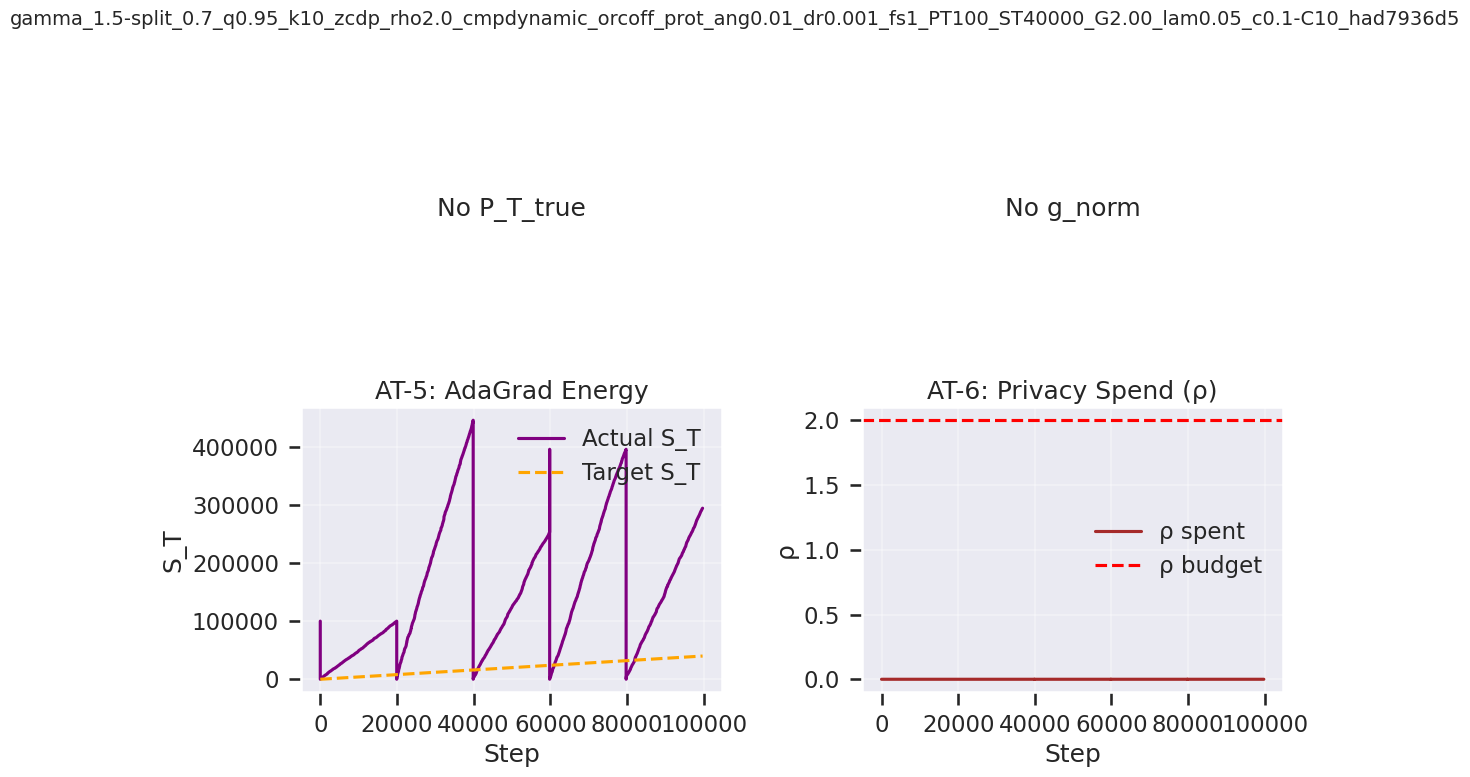


=== Grid: gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a ===
{'gamma_bar': 0.6, 'gamma_split': 0.5, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 1, 'rho_total': 0.5, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.05, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 250.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31/sweep/gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,0,0.005055,9475,9475,NaN,NaN,55782.740170,0.394569,NaN,NaN,NaN,AT-5 ST err 39.5%
1,1,0.275151,9475,9475,NaN,NaN,212551.009219,4.313775,NaN,NaN,NaN,AT-5 ST err 431.4%
2,2,0.126832,9475,9475,NaN,NaN,131211.415139,2.280285,NaN,NaN,NaN,AT-5 ST err 228.0%
3,3,0.005088,9359,9359,NaN,NaN,93384.195373,1.334605,NaN,NaN,NaN,AT-5 ST err 133.5%
4,4,0.288632,8419,8418,NaN,NaN,288162.753913,6.204069,NaN,NaN,NaN,AT-5 ST err 620.4%


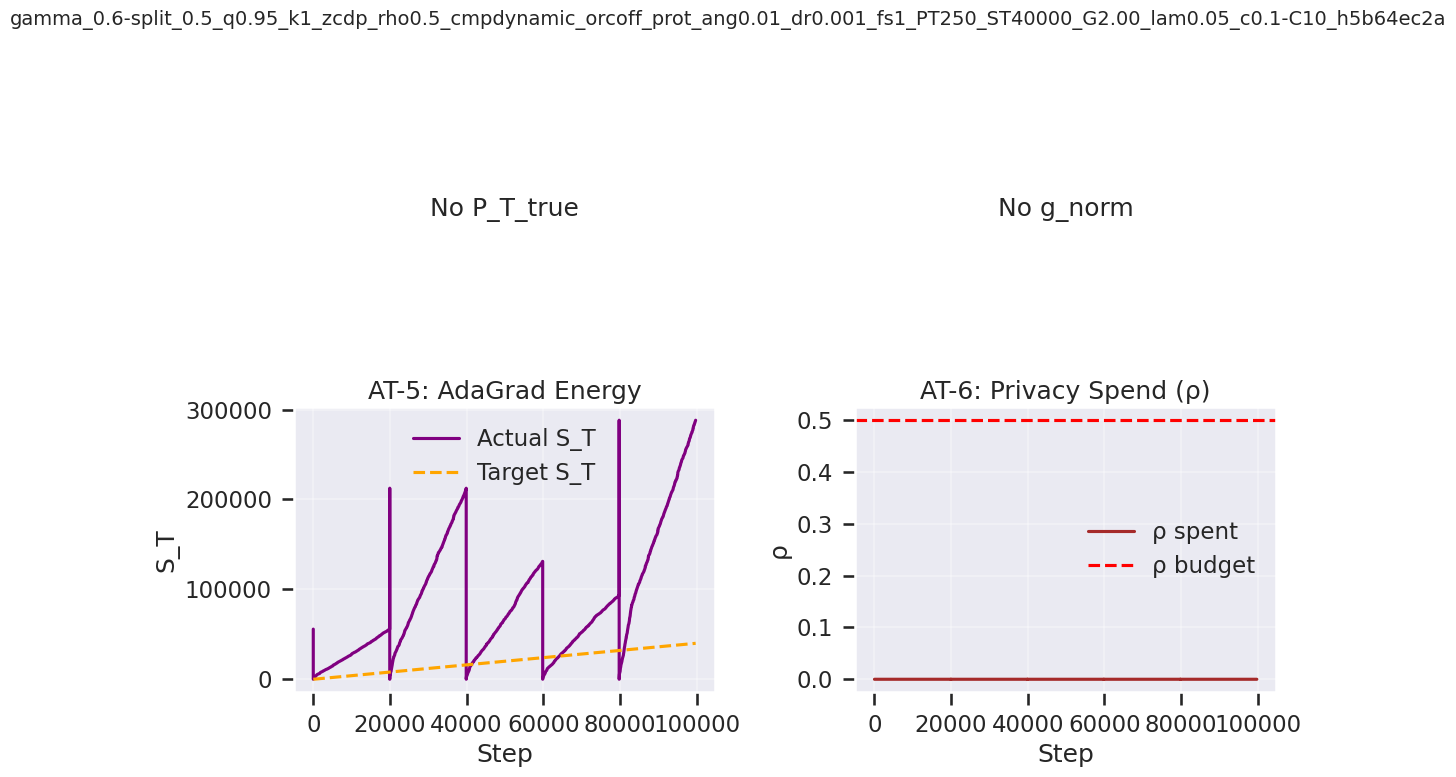


=== Grid: gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b ===
{'gamma_bar': 0.6, 'gamma_split': 0.5, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 10, 'rho_total': 0.5, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.05, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 250.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31/sweep/gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,0,0.004699,17228,1722,NaN,NaN,94794.070208,1.369852,NaN,NaN,NaN,AT-5 ST err 137.0%
1,1,0.276541,17228,1722,NaN,NaN,367127.663211,8.178192,NaN,NaN,NaN,AT-5 ST err 817.8%
2,2,0.125039,17228,1722,NaN,NaN,223426.263361,4.585657,NaN,NaN,NaN,AT-5 ST err 458.6%
3,3,0.003606,17017,1701,NaN,NaN,158146.205303,2.953655,NaN,NaN,NaN,AT-5 ST err 295.4%
4,4,0.284835,15307,1530,NaN,NaN,456176.116739,10.404403,NaN,NaN,NaN,AT-5 ST err 1040.4%


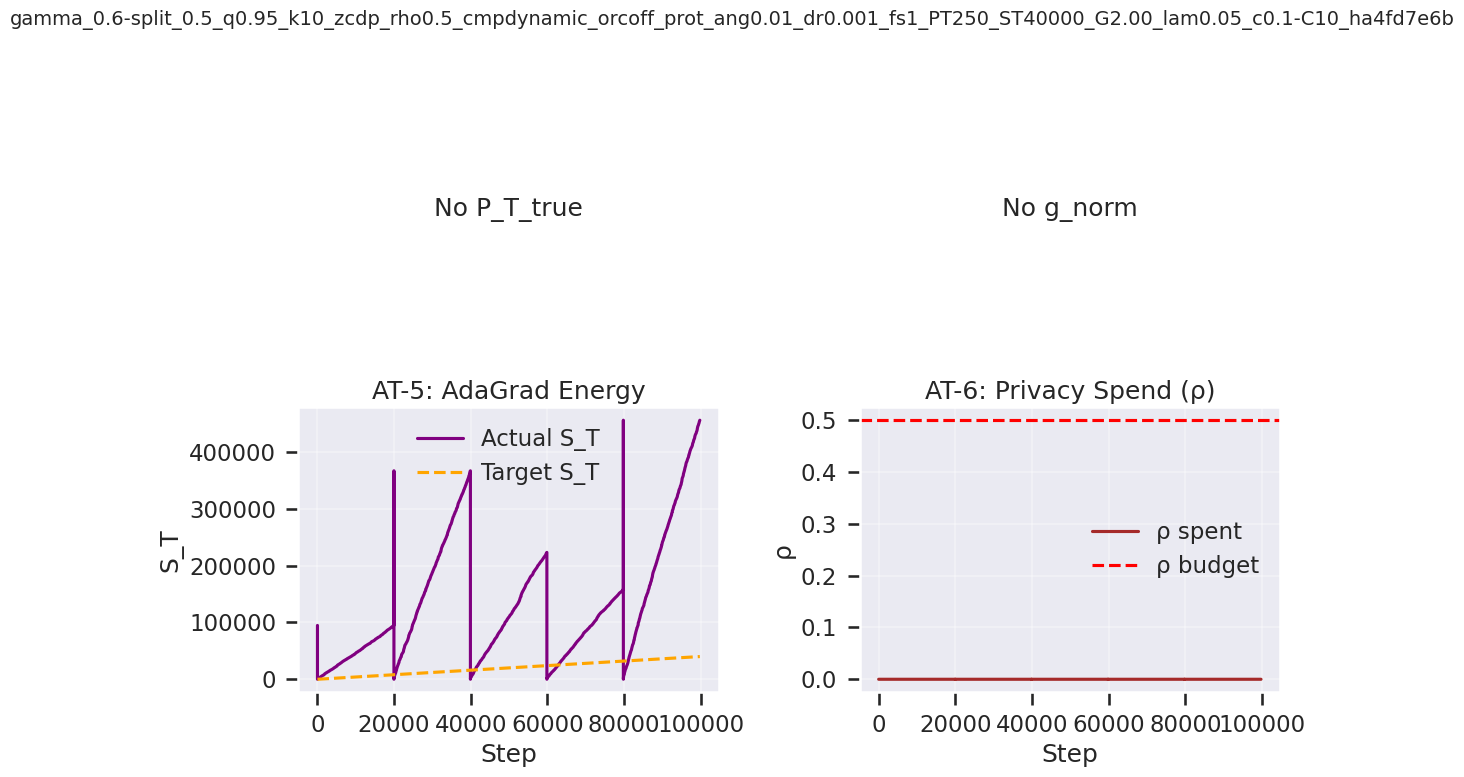

,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,AT1_PT,AT2_G_clip,AT5_ST,AT6_privacy,grid_id
0,NaN,NaN,294571.408175,6.364285,NaN,NaN,0.0,None,False,False,True,gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpd...
1,NaN,NaN,288162.753913,6.204069,NaN,NaN,0.0,None,False,False,True,gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdy...
2,NaN,NaN,456176.116739,10.404403,NaN,NaN,0.0,None,False,False,True,gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpd...


In [8]:
all_metrics = []
grid_summaries = []

for g in sampled:
    params = load_params(g)
    params["__grid_path__"] = g
    grid_id = os.path.basename(g)
    print(f"\n=== Grid: {grid_id} ===")
    print(params)

    # Seed-level summaries (if produced by agents/process_seed_output)
    seed_df = load_seed_summary(g)
    if not seed_df.empty:
        # small view of top columns if present
        cols_show = [c for c in ["seed","avg_regret_empirical","N_star_emp","m_emp","PT_final","PT_error","ST_final","ST_error","max_g_norm","avg_clip_rate","rho_spent_final","blocked_reason"] if c in seed_df.columns]
        display(seed_df[cols_show])

    # Event-level loading (robust)
    usecols = None  # keep all for now; set to a reduced list to speed up
    ev = load_event_csvs(g, usecols=usecols)
    if ev.empty:
        print("No event-level data found.")
        continue

    # Compute acceptance metrics from events
    metrics = compute_acceptance_metrics(ev, params)
    metrics["grid_id"] = grid_id
    all_metrics.append(metrics)

    # Compact multi-panel figure
    quick_panel_plots(ev, params, title=f"{grid_id}")

# Aggregate acceptance metrics across the 3 cells
acc_df = pd.DataFrame(all_metrics)
display(acc_df)

## Analysis Tasks

WRITE THEM HERE.

## Analysis from the Results Above

A lof of the experiment results aren't making it to logs. For example, the `P_T error` and `P_T final` are almost universally missing, indicating that the event CSVs aren't ingesting their full metric capacity. 

Missing Seed Fields
`PT_final`
`max_g_norm`
`clip_rate`
`rho_spent_final`

Missing Event Fields
`P_T_true`
`g_norm`
`clip_applied`
`privacy_spend_running`

The missing fields prevent completion of Analysis Tasks 1, 2, and 6.

Thanks for sharing the notebook and context. Here’s what I see and what I’d do next.

1) Can I read the code and outputs?
- Yes. I can read the notebook code you ran (helpers to list cells, load params/CSVs, acceptance metrics, panel plots).
- I also see the outputs:
  - “Found 108 grid cells”
  - Sampled grid ids (e.g., gamma_1.5-split_0.7_… PT100_ST40000_G2.00 …)
  - A per-seed table for that grid with columns like avg_regret_empirical, N_star_emp, m_emp, ST_final, ST_error, and blocked_reason
  - The 2×2 diagnostic plot rendered

2) Interpretation of the results so far
- AT-5 (AdaGrad energy S_T) fails badly in the sampled grid cell:
  - target_ST = 40,000 (from params), but ST_final is 100,082 up to 395,981 depending on seed.
  - ST_error ranges from 150% to 890% and every seed is marked with “AT-5 ST err …”.
  - This is a strong signal that the cumulative squared gradients are substantially higher than the theory target. A quick back-of-the-envelope: with T ≈ 20,000 and target G = 2.0, the worst-case bound S_T ≈ G^2·T ≈ 80,000. Several runs exceed even that (up to ~396k), suggesting average gradient norms are larger than assumed or that target_ST is set too low for these settings.
- Other acceptance signals are missing (AT-1/PT, AT-2/G+clip, AT-6/privacy):
  - PT_final, max_g_norm, clip_rate, rho_spent_final are NaN in the per-seed summary.
  - This isn’t only a data issue in your analysis code; the event CSVs being produced by the runner don’t currently carry through the theory-stream diagnostics like P_T_true, g_norm, clip_applied, privacy_spend_running. In phases._create_extended_log_entry we don’t merge the event’s metrics payload into the CSV row, so those fields never make it into the outputs. That’s why AT-1/2/6 can’t be computed from your seed/event CSVs.
- Regret varies across seeds:
  - avg_regret_empirical ranges from ~0.011 to ~0.218 across seeds in the same grid cell, which is a big spread and worth investigating (it may correlate with S_T growth and/or step-size policy).
- N_star and workload balance:
  - N_star_emp ~ 17,228 and m_emp ~ 1,722. With delete_ratio=10, that’s consistent (≈1 delete per 10 inserts). With T≈20,000, most events are inserts to reach N*, leaving a relatively small but non-trivial interleaving window.

What stands out / hypotheses
- The AT-5 failures suggest the observed gradient norms are larger than the assumed bound (G=2), or the target_ST is too tight for T and the current lambda_reg/step-size policy. Since S_scalar only accumulates inserts, the high S_T isn’t from deletes.
- Missing P_T_true, g_norm, clip_applied, and privacy spend in the event logs is blocking a full acceptance audit (AT-1/2/6). You likely are meeting some of these but can’t verify without logging the theory stream metrics.
- The spread in avg_regret across seeds likely correlates with how quickly S_T grows (and possibly whether the policy operated in strongly-convex vs. adagrad mode and with what effective λ).

3) What further analysis I’d run next
A. Fix logging to unblock a full acceptance audit
- Merge the theory-stream metrics into the CSV rows so you can compute AT-1/2/6 from event-level files:
  - From parse_event_record(record), grab meta["metrics"] (which includes P_T_true, g_norm, clip_applied, ST_running, PT/ST residuals, privacy_spend_running) and merge into the log entry in phases._create_extended_log_entry. This will populate P_T_true, g_norm, clip_applied, privacy_spend_running in seed_*_events.csv.
  - In your aggregator, also look for 'rho_spent' (the zCDP adapter emits rho_spent), not just 'privacy_spend' or 'privacy_spend_running'.
Once this is in, your existing acceptance code in the notebook will work end-to-end.

B. Quantify AT pass rates across all 108 grid cells
- Compute AT-1/2/5/6 per seed using event-level CSVs and summarize pass/fail rates per grid cell.
- Produce heatmaps of pass rates vs:
  - gamma_bar × gamma_split
  - rho_total × delete_ratio
  - path_style × target_PT
  - lambda_reg × target_ST
- This directly answers your success criteria (“95% of cells meet their guarantees?”) and shows where failures cluster.

C. Diagnose the S_T blow-up
- Add two derived checks per run:
  - ST_final / target_ST
  - ST_final / (target_G^2 · T)
- Visualize distributions and scatter plots:
  - ST_final vs. G^2·T (line at y=x); runs far above the line indicate G underestimation or step-size/regularization issues.
  - ST_error vs avg_regret_empirical (Spearman correlation to see if higher S_T drives higher regret).
- Use quick_panel_plots for failing cells (now with ST_running) to visualize growth and compare against target line—this will confirm if S_T growth is linear, super-linear, or dominated by early spikes.

D. Reassess gradient/clipping and PT adherence (after logging is fixed)
- For AT-2:
  - Check whether max_g_norm ≤ 1.05 G and clip_rate ≤ 5%.
  - If max_g_norm regularly exceeds the bound, consider increasing target_G or increasing lambda_reg to pull gradients down.
- For AT-1:
  - Compare final P_T_true to target_PT; plot per-step PT vs target line to see if the PT controller is too conservative/aggressive.
- For AT-6:
  - Plot rho_spent_running over time with a horizontal line at rho_total; confirm no overspend and how close you get by the end.

E. Explore sensitivity to learning-rate policy and λ
- Use the logged step-size policy fields ('stepsize_policy', 'eta_t', 'base_eta_t', 'sc_active') to:
  - Compare runs where strongly-convex policy engaged vs adagrad.
  - Test whether larger lambda_reg reduces S_T error and avg_regret (box/violin plots of metrics grouped by lambda_reg).
- If strongly-convex policy rarely engages (λ estimate not stable), consider adjusting lambda_stability_K or lambda_min_threshold to activate it sooner, and see if that narrows S_T.

F. End-to-end seed variability and robustness
- Violin/box plots of avg_regret_empirical, ST_error across seeds for each grid cell to quantify variability.
- Flag cells with high between-seed variance—these are good candidates for debugging or parameter tuning.

G. Optional tests
- If clip_applied gets logged, compute clip rate time series and verify it stays under 5% (AT-2).
- If N_gamma is logged per event, measure what fraction of runs ever reach the “predictions enabled” state and whether that correlates with acceptance.

Small code suggestions to implement (A)
- In experiments/deletion_capacity/phases.py, inside _create_extended_log_entry, after you prepare entry:
  - Merge the current record’s metrics:
    - metrics = meta.get("metrics", {}) and for each (k, v) not already in entry, set entry[k] = v
  - This will carry P_T_true, g_norm, clip_applied, ST_running, PT_target_residual, ST_target_residual, privacy_spend_running into the CSV.
- In your notebook’s acceptance function, also treat 'rho_spent' as privacy spend in case 'privacy_spend_running' is missing in older runs.

Bottom line
- The data you’ve examined clearly shows AT‑5 failing; that’s the primary signal so far.
- To understand whether the failures come from a too-tight target_ST, underestimation of G, or step-size/λ choices, you need P_T_true, g_norm, clip_applied, and rho_spent logged at the event level. Once those are in the CSVs, you can run the acceptance audit and heatmaps across all 108 cells and quickly see where to adjust the theory targets or learning schedule.